# Evolutionary Robot Path Planning

In [214]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from shapely import LineString, MultiLineString, MultiPolygon, Point, clip_by_rect, box, affinity, ops, contains_xy
from shapely.plotting import plot_polygon, plot_line
from matplotlib import animation
from IPython.display import clear_output


In [215]:
class Obstacle:

    def __init__(self, xlim: tuple, ylim: tuple, permeability=1, velocity=(0, 0)):
        self.xlim = np.array(xlim)
        self.ylim = np.array(ylim)
        self.shape = box(xlim[0], ylim[0], xlim[1], ylim[1])
        self.permeability = permeability
        self.velocity = velocity

    def update_position(self):
        self.xlim += self.velocity[0]
        self.ylim += self.velocity[1]


In [ ]:
class Robot:
    """Agent class representing the robot."""

    def __init__(self, loc, target, params):
        """Initializes the attributes.
        loc: tuple(x,y) representing robots current/start coordinates
        fit_land: FtinessLandscape object
        target: tuple(x,y) representing target coordinates
        """
        self.loc = Point(loc)
        self.target = Point(target)
        self.obstacles = MultiPolygon()
        self.artists = []

        # Evolutionary params
        self.evolutionary = params.get('evolutionary', True)
        self.population_size = params.get('population_size', 100)
        self.selection_size = params.get('selection_size', 10)
        self.search_step = params.get('search_step', 0.1)
        self.iterations = params.get('iterations', 100)
        self.kstart = params.get('kstart', 5)

        # Sensor and actuator params
        self.view_distance = params.get('view_distance', 20) # Must be >= move_distance
        self.move_distance = params.get('move_distance', 10)
        self.turn_angle = params.get('turn_angle', 180) # Max turning angle in degrees

        # Sensor and actuator values
        self.view = clip_by_rect(self.loc.buffer(self.view_distance), 0, 0, self.target.x, self.target.y)
        self.move_circle = clip_by_rect(self.loc.buffer(self.move_distance), 0, 0, self.target.x, self.target.y)
        self.move_range = self.move_circle

        self.init_agents = self.create_agents()

        # History
        self.num_steps = 0
        self.pathHist = []
        self.optimal_seq = []
        self.fitness_seq = []

    def create_agents(self):
        x = []
        y = []
        k = self.kstart
        spacing = range(k, k**2+1, k)
        interval = self.move_distance / k

        for i, n in enumerate(spacing):
            t = np.linspace(0, 2*np.pi, n, endpoint=False)
            scale = i*interval
            x.extend(scale * np.cos(t))
            y.extend(scale * np.sin(t))
            
        return np.c_[x, y]

    def find_local_objective(self):
        if self.move_range.contains(self.target):
            return self.target

        iterations = self.iterations
        loc = self.loc

        # Initialize agents at current location and evaluate their fitness
        # agents are locations in the robots movement radius
        agents = self.init_agents + np.array([[loc.x, loc.y]])
        selected_agents, fitness = self.select_agents(agents)
        self.optimal_seq.append(selected_agents[0])
        self.fitness_seq.append(fitness[0])
        optimal_agent = selected_agents[0]
        optimal_fitness = fitness[0]

        for _ in range(iterations):
            agents = self.mutate_agents(selected_agents)
            selected_agents, fitness = self.select_agents(agents)
            self.optimal_seq.append(selected_agents[0])
            self.fitness_seq.append(fitness[0])
            if fitness[0] < optimal_fitness:
                optimal_fitness = fitness[0]
                optimal_agent = selected_agents[0]
        
        return Point(optimal_agent[0], optimal_agent[1])

    def select_agents(self, agents):
        selection_size = self.selection_size
        fitness = self.evaluate_fitness(agents)

        # Sort agents and fitness arrays by their fitness
        fitind = np.argsort(fitness)
        fitness = fitness[fitind]
        agents = agents[fitind]

        # Get the selected agents
        current_num_agents = agents.shape[0]
        selected_agents = np.copy(agents)
        if selection_size <= current_num_agents:
            selected_agents = selected_agents[:selection_size-1]

        return selected_agents, fitness

    def mutate_agents(self, selected_agents):
        population_size = self.population_size
        search_step = self.search_step

        num_selected = selected_agents.shape[0]
        num_offspring = population_size//num_selected
        num_additional = population_size%num_selected
        x_offspring = []
        y_offspring = []

        # Generate offspring
        for agent in selected_agents[num_additional:]:
            rand_angles = np.random.uniform(0, 2*np.pi, num_offspring)
            x_offspring.extend(agent[0] + search_step*np.cos(rand_angles))
            y_offspring.extend(agent[1] + search_step*np.sin(rand_angles))

        num_offspring += 1
        for agent in selected_agents[:num_additional-1]:
            rand_angles = np.random.uniform(0, 2*np.pi, num_offspring)
            x_offspring.extend(agent[0] + search_step*np.cos(rand_angles))
            y_offspring.extend(agent[1] + search_step*np.sin(rand_angles))

        return np.c_[x_offspring, y_offspring]

    def evaluate_fitness(self, agents):
        target_x = self.target.x
        target_y = self.target.y
        move_range = self.move_range
        obstacles = self.obstacles

        fitness = np.sqrt(np.square(agents[:, 0] - target_x) + np.square(agents[:, 1] - target_y))

        if obstacles.is_empty == False:
            # Could experiment / tweak values to find better ways to penalize proximity to objects 
            # fitness -= [0.35*(obstacles.distance(Point(agent))) for agent in agents]
            fitness += [10/(obstacles.distance(Point(agent)) + 1) for agent in agents]
        
        out_range = contains_xy(move_range, agents[:, 0], agents[:, 1]) == False
        fitness[out_range] = np.inf
        
        return fitness

    def find_waypoint(self):
        """Returns the coordinates for the next motion as a Point object.

        TODO: Doesn't necessarily have to always go full distance,
        maybe edit so step_distance is treated as the max travel distance 
        rather than the distance for every step
        """

        # Calculate ideal waypoint as straight line from robot towards target
        # Using view_distance so it calculates based what it sees beyond where it can move
        idealWaypoint = LineString([self.loc, self.target]).interpolate(self.view_distance)
        idealPath = LineString([self.loc, idealWaypoint])

        path = idealPath
        rng = np.random.default_rng()

        # If the chosen path intersects with a detected obstacle, rotate the path a random amount up to self.turn_angle degrees
        while self.obstacles.intersects(path):
            path = affinity.rotate(path, rng.integers(self.turn_angle), (self.loc.x, self.loc.y))


        return path.interpolate(self.move_distance)
    
    def step(self, env):
        """Performs motion to next calculated waypoint and updates history."""

        if self.evolutionary:
            next = self.find_local_objective()
        else:
            next = self.find_waypoint()
        path = LineString([self.loc, next])
        self.pathHist.append(path) 
        self.loc = next
        self.view = clip_by_rect(self.loc.buffer(self.view_distance), 0, 0, env.size[0], env.size[1])
        self.move_circle = clip_by_rect(self.loc.buffer(self.move_distance), 0, 0, env.size[0], env.size[1])
        self.move_range, self.obstacles = env.detect_obstacles(self)
        self.num_steps += 1
        
    def draw(self, ax):
        """Plots the robot path."""

        # If robots have different targets or start points, uncomment
        #ax.plot(self.loc.x, self.loc.y, 'bX', markersize=7, zorder=100)
        #ax.plot(self.target.x, self.target.y, 'r*', markersize=10)

        self.artists.clear()
        hist = MultiLineString(self.pathHist)
        
        container = ax.plot(self.loc.x, self.loc.y, 'o', markersize=7, zorder=100, color='darkorange')
        self.artists.append(container)
        container = plot_line(hist, ax=ax, linestyle=':', ec='black', color='lightblue')
        self.artists.append(container[0])
        container = plot_polygon(self.obstacles, ax=ax, color=(1, 0, 0, 1), add_points=False)
        self.artists.append(container)
        container = plot_polygon(self.view, ax=ax, add_points=False, linestyle='--', edgecolor='blue', facecolor=(0,0,0,0))
        self.artists.append(container)
        container = plot_polygon(self.move_range, ax=ax, add_points=False, linestyle='--', edgecolor='green', facecolor=(0,0,0,0))
        self.artists.append(container)


        return self.artists
    

In [217]:
from time import sleep


class Simulation:
    
    def __init__(self, size: tuple, start : tuple, objective: tuple):
        self.size = size
        self.start = start
        self.objective = objective
        
        self.obstacles = []
        self.robot = Robot(self.start, self.objective, dict())

        self.fig, self.ax = plt.subplots()
        
    def add_obstacles(self, obstacles):
        self.obstacles.extend(obstacles)
            
    def detect_obstacles(self, robot: Robot):
        """Returns polygons representing visible parts of obstacles to robot.
        TODO: Should robot remember past detected obstacles? So if it revisits an area it would already know of the obstacle
        """
        
        move_range = robot.move_circle
        obstacles = []

        for obstacle in self.obstacles:
            if obstacle.shape.overlaps(robot.move_circle):
                move_range = move_range.intersection(self.raycast(obstacle, robot.loc, robot.move_distance, robot.move_circle))
            if obstacle.shape.overlaps(robot.view):
                obstacles.append(obstacle.shape.intersection(robot.view))

        return move_range, MultiPolygon(obstacles)
    
    def raycast(self, obstacle, loc, radius, circle):
        loc_x = loc.x
        loc_y = loc.y

        # Get limiting obstacle vertices 
        x1, x2 = obstacle.xlim
        y1, y2 = obstacle.ylim
        vertices = np.array([[x1, y1], [x1, y2], [x2, y1], [x2, y2]])        
        angle = np.arctan2(vertices[:, 1] - loc_y, vertices[:, 0] - loc_x)
        sorted_vertices = np.c_[vertices, angle]
        sorted_vertices = sorted_vertices[sorted_vertices[:, 2].argsort()]

        # Get ray intersections with radius
        ray1 = []
        ray2 = []
        vertex1 = (sorted_vertices[0, 0], sorted_vertices[0, 1])
        vertex2 = (sorted_vertices[-1,0], sorted_vertices[-1, 1])
        ray1.append(vertex1)
        ray2.append(vertex2)
        ray1.append(self.intersect_radius((loc_x, loc_y), sorted_vertices[0, 2], radius))
        ray2.append(self.intersect_radius((loc_x, loc_y), sorted_vertices[-1, 2], radius))

        ray1.sort(key=lambda p: np.sqrt(np.square(p[0] - loc_x) + np.square(p[1] - loc_y)))
        ray2.sort(key=lambda p: np.sqrt(np.square(p[0] - loc_x) + np.square(p[1] - loc_y)))

        diff_range = circle.difference(obstacle.shape)
        contains_vertex1 = circle.contains(Point(vertex1[0], vertex1[1]))
        contains_vertex2 = circle.contains(Point(vertex1[0], vertex1[1]))
        
        if contains_vertex1 and contains_vertex2:
            collection = ops.split(circle, LineString([ray1[1], ray1[0], ray2[0], ray2[1]]))
            raypoly = collection.geoms[1] if collection.geoms[1].contains(loc) else collection.geoms[0]
        elif contains_vertex1:
            collection = ops.split(diff_range, LineString([ray1[0], ray1[1]]))
            raypoly = collection.geoms[1] if collection.geoms[1].contains(loc) else collection.geoms[0]
        elif contains_vertex1:
            collection = ops.split(diff_range, LineString([ray2[0], ray2[1]]))
            raypoly = collection.geoms[1] if collection.geoms[1].contains(loc) else collection.geoms[0]
        else:
            raypoly = diff_range

        return raypoly

    def intersect_radius(self, center, angle, radius):
        radius_x = center[0] + radius * np.cos(angle)
        radius_y = center[1] + radius * np.sin(angle)
        return radius_x, radius_y

    def draw(self):
        """Plots obstacles, start/target coords, and path/view of each robot"""
        self.ax.set_xlim(0, self.size[0])
        self.ax.set_ylim(0, self.size[1])

        obstacles = MultiPolygon([obs.shape] for obs in self.obstacles)
        plot_polygon(obstacles, ax=self.ax, color='black', add_points=False)
        self.ax.plot(self.start[0], self.start[1], 'bX', markersize=7, zorder=10)
        self.ax.plot(self.objective[0], self.objective[1], 'r*', markersize=10)

    def animate(self):
        # Remove previous artists for rerender
        [artist.remove() if type(artist) is not list else artist[0].remove() for artist in self.robot.artists]
        artists = [self.robot.draw(self.ax)]
        return artists

    def run_full(self):
        """Run simulation and plot every 1s until all robots reach target"""
        self.draw()
        while self.robot.loc != self.robot.target:  
            self.animate()
            display(self.fig)
            sleep(0.5)
            self.robot.step(self)
            clear_output(wait=True)
        
        self.animate()
            

87.52548291574007


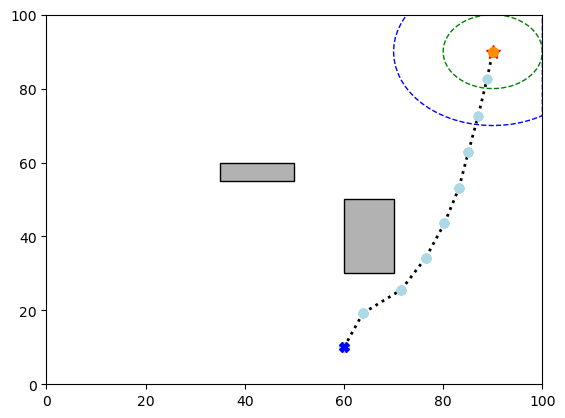

In [218]:
# Test
start = (60, 10)
objective = (90, 90)
sim = Simulation((100, 100), start, objective)

obstacles = (Obstacle((35, 50), (55, 60)), Obstacle((60, 70), (30, 50)))
sim.add_obstacles(obstacles)
sim.run_full()

sum = 0
for line in sim.robot.pathHist:
    sum += line.length
print(sum)